In [156]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display_html
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, OneHotEncoder

# Display estimators as diagrams in Jupyter notebook
set_config(display='diagram')

plt.rcParams["figure.figsize"] = (12,8)

In [157]:
def getFeatureNames(columnTransformer, selector=None):
    """ Extract feature names from column transformer object. 
        If transformers are pipelines the one-hot encoding step
        should be last step of that pipeline.
    """
    colNames = np.array([])
    for tupleTransformer in columnTransformer.transformers_[:-1]:
        if isinstance(tupleTransformer[1], Pipeline): 
            transformer = tupleTransformer[1].steps[-1][1]
        else:
            transformer = tupleTransformer[1]
        try:
            # One hot encoded names have x0_, x1_ etc.
            names = transformer.get_feature_names()
            trueNames = tupleTransformer[-1]
            # Get dict mapping transformed name to true name
            nameMap = {f'x{i}_' : name for i, name in enumerate(trueNames)}
            # Swap transformed name with true name
            for i, name in enumerate(names):
                prefix = name[:3]
                names[i] = f'{nameMap[prefix]}_{name[3:]}'
        except AttributeError:
            names = tupleTransformer[2]
        # This is for kBinDiscretizers, which have n_bins_ method
        if (isinstance(transformer, KBinsDiscretizer)
                and transformer.encode != 'ordinal'):
            if transformer.encode != 'ordinal':
                nBins = transformer.n_bins_
                newNames = []
                for col, n in zip(names, nBins):
                    newNames = [f'{col}-{i}' for i in range(n)]
                names = newNames
        colNames = np.append(colNames, names)
    if selector is not None:
        colNames = colNames[selector.get_support()]
    return colNames

In [189]:
def getSeason(x):
    if x < 6 and x > 2:
        return 'spring'
    elif x < 9 and x > 5:
        return 'summer'
    elif x < 12 and x > 8:
        return 'autumn'
    else:
        return 'winter'

In [250]:
# Define paths to test and training data
data = '/Users/user/Documents/OneDrive - Nexus365/PhD/Campy_Analysis_ALL/Data/CleanMeta_for_Tableau_resistantcleaned_10362.csv'
target = 'Gyrase_DessyPipeline'
index = 'id'

# Read training data
X = pd.read_csv(data, index_col=index)

# Drop target from X and save to seperate variable
X[target] = X[target].apply(lambda x: 1 if x == 'I' else 0)

y = X[target]

X['season'] = X['month'].apply(getSeason)

# Split data from training and testing
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=0, train_size=0.8, test_size=0.2)

In [251]:
X.head()

,isolate,country,region,region_Tableau,year,month,age_yr,sex,disease,source,...,uncA,ST..MLST.,clonal_complex..MLST.,Cjc_cgc_200,Cjc_cgc_100,Cjc_cgc_50,Cjc_cgc_25,Cjc_cgc_10,Cjc_cgc_5,season
id,,,,,,,,,,,,,,,,,,,,,
2659,H133940557,UK,Oxfordshire,Oxfordshire,2013.0,NaN,NaN,NaN,NaN,human stool,...,5,918,ST-48 complex,84.0,19.0,20.0,22.0,23.0,23.0,winter
2663,H134660450,UK [England],West Midlands,Other,2013.0,11.0,45.0,male,NaN,human stool,...,1,524,ST-353 complex,20.0,21.0,22.0,24.0,25.0,25.0,autumn
2670,H140620012,UK [England],"Bedfordshire, Hertfordshire and Northamptonshire",Other,2014.0,2.0,90.0,female,gastroenteritis,human stool,...,5,50,ST-21 complex,23.0,24.0,25.0,27.0,28.0,28.0,winter
2672,H140940808,UK [England],Cumbria and Lancashire,Other,2014.0,2.0,68.0,female,gastroenteritis,human stool,...,6,354,ST-354 complex,25.0,26.0,27.0,29.0,30.0,30.0,winter
5858,OXC1,UK [England],Oxfordshire,Oxfordshire,2003.0,9.0,NaN,male,gastroenteritis,human stool,...,5,21,ST-21 complex,22.0,23.0,37.0,42.0,44.0,2012.0,autumn


In [252]:
X.columns

Index(['isolate', 'country', 'region', 'region_Tableau', 'year', 'month',
       'age_yr', 'sex', 'disease', 'source', 'epidemiology', 'species',
       'comments', 'ciprofloxacin_phenotype', 'Gyrase_DessyPipeline',
       'IT_to_RS_conversion', 'Phenotype_genotype_crossCheck_0.05%discrepancy',
       'fluoroquinolone_genotypes_1_PHEpipeline',
       'fluoroquinolone_genotypes_2_AlisonPipeline',
       'tetracycline_genotypes_1_PHE',
       'tetracycline_genotypes_2_AlisonPipeline', 'tetracycline_phenotype',
       'aspA', 'glnA', 'gltA', 'glyA', 'pgm', 'tkt', 'uncA', 'ST..MLST.',
       'clonal_complex..MLST.', 'Cjc_cgc_200', 'Cjc_cgc_100', 'Cjc_cgc_50',
       'Cjc_cgc_25', 'Cjc_cgc_10', 'Cjc_cgc_5', 'season'],
      dtype='object')

In [296]:
categoryTransformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

numericTransformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
])

transformers = [
    ('categories', categoryTransformer,  ['region_Tableau','sex','season']),
    ('year',       numericTransformer, ['year']),
]

transformers = [
    ('categories', categoryTransformer,  ['clonal_complex..MLST.']),
    ('year',       numericTransformer, ['year']),
]

preProcessor = ColumnTransformer(transformers=transformers, remainder='drop')

In [297]:
# Combine processor and modelling steps into a Pipeline object
model = Pipeline(steps=[
    ('preProcess'     , preProcessor),  
    ('estimator'      , RandomForestClassifier()),
])

In [298]:
# Train model
model.fit(X_train, y_train)
print(f'Validation Score: {model.score(X_valid, y_valid):3.2%}')
model # Display model object

Validation Score: 76.31%


Pipeline(steps=[('preProcess',
                 ColumnTransformer(transformers=[('categories',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['clonal_complex..MLST.']),
                                                 ('year',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer())]),
                                                  ['year'])])),
                ('estimator', RandomForestClassifier())])

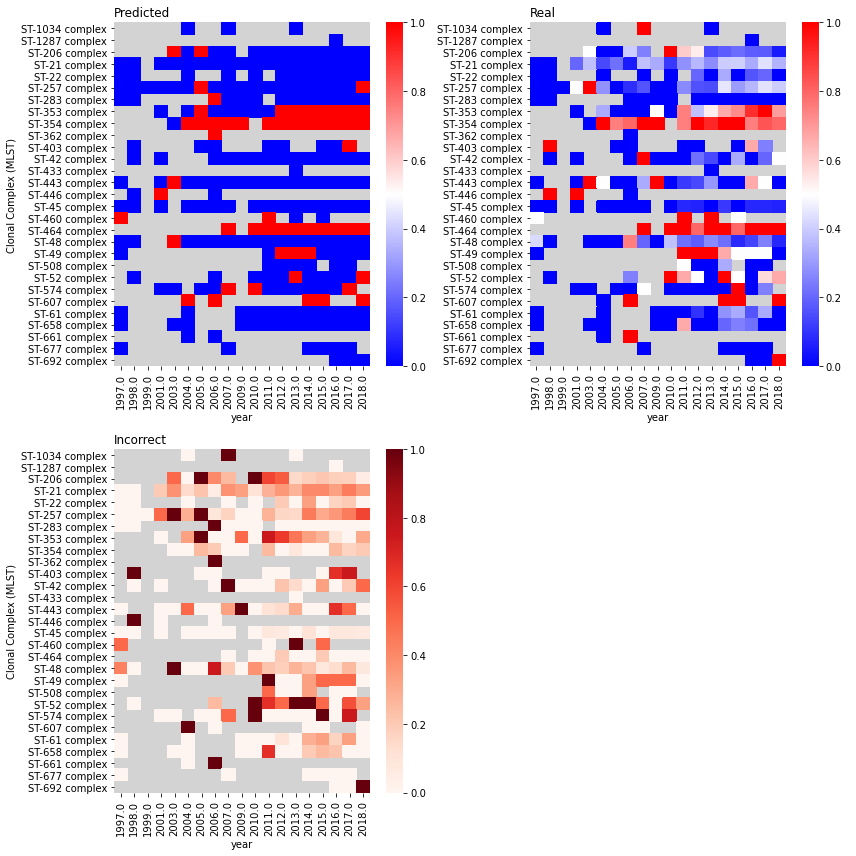

In [299]:
X_valid = X_valid.copy()
X_valid[target] = y_valid

dat = X_valid

dat = dat.copy()
dat['predicted'] = model.predict(dat)

fig, axes = plt.subplots(2, 2, figsize=(12,12))
ax1, ax2, ax3, ax4 = axes.flatten()
dataPredicted = (dat.groupby(['year', 'clonal_complex..MLST.'])['predicted']
 .mean()
 .reset_index().pivot(index='clonal_complex..MLST.', columns='year', values='predicted'))
g = sns.heatmap(data=dataPredicted, yticklabels=1, vmin=0, vmax=1, cmap='bwr', ax=ax1)
g.set_facecolor('lightgrey')
ax1.set_title('Predicted', loc='left')

dataReal = (dat.groupby(['year', 'clonal_complex..MLST.'])[target]
 .mean()
 .reset_index().pivot(index='clonal_complex..MLST.', columns='year', values=target))
g = sns.heatmap(data=dataReal, yticklabels=1, cmap='bwr', ax=ax2)
g.set_facecolor('lightgrey')
ax2.set_title('Real', loc='left')
                
g = sns.heatmap(data=(dataReal-dataPredicted).abs(), yticklabels=1, cmap='Reds', ax=ax3)
g.set_facecolor('lightgrey')
ax3.set_title('Incorrect', loc='left')

ax1.set_ylabel('Clonal Complex (MLST)')
ax3.set_ylabel('Clonal Complex (MLST)')
ax2.set_ylabel('')
ax4.axis('off')
fig.tight_layout()

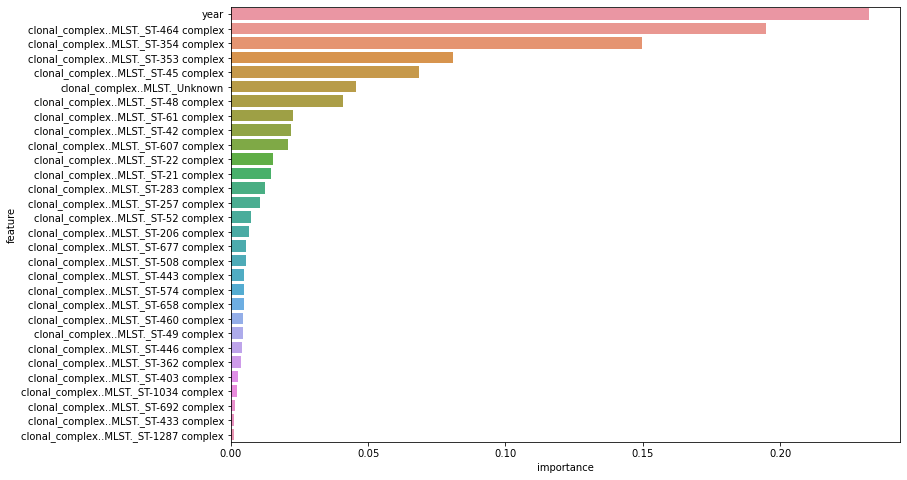

In [300]:
featureNames = getFeatureNames(preProcessor)
features = (pd.DataFrame(
        {'feature': featureNames,
         'importance': model.named_steps['estimator'].feature_importances_})
        .sort_values(by=['importance'], ascending=False))
features = features.sort_values('importance', ascending=False).head(30)
fig, ax = plt.subplots()
sns.barplot(y='feature', x='importance', data=features, ax=ax)

In [93]:
featureNames = [x.split()[0][22:] if x.startswith('clonal') else x for x in featureNames]

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

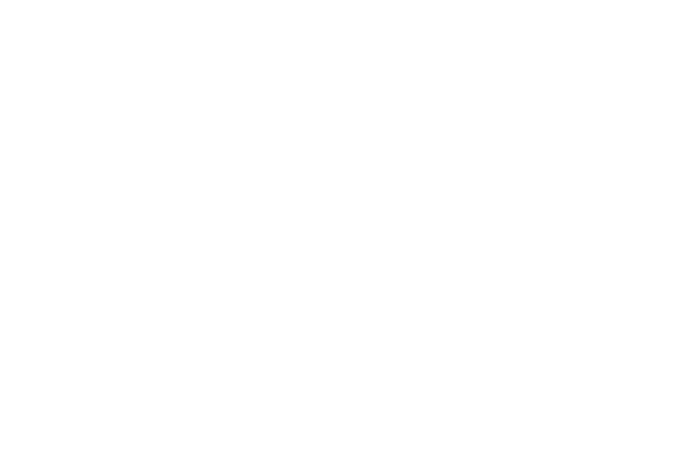

In [94]:

_ = plot_tree(
    decision_tree=model.named_steps['estimator'], 
    feature_names=featureNames, max_depth=3,
    class_names=['S', 'R'], filled=True)

In [53]:
_

[Text(334.8, 380.52, 'clonal_complex..MLST._ST-464 complex <= 0.5\ngini = 0.435\nsamples = 8289\nvalue = [2652, 5637]\nclass = x'),
 Text(167.4, 271.8, 'clonal_complex..MLST._ST-354 complex <= 0.5\ngini = 0.417\nsamples = 8004\nvalue = [2374, 5630]\nclass = x'),
 Text(83.7, 163.07999999999998, 'clonal_complex..MLST._ST-353 complex <= 0.5\ngini = 0.397\nsamples = 7685\nvalue = [2098, 5587]\nclass = x'),
 Text(41.85, 54.360000000000014, 'gini = 0.377\nsamples = 7297\nvalue = [1840, 5457]\nclass = x'),
 Text(125.55000000000001, 54.360000000000014, 'gini = 0.446\nsamples = 388\nvalue = [258, 130]\nclass = y'),
 Text(251.10000000000002, 163.07999999999998, 'year <= 2011.5\ngini = 0.233\nsamples = 319\nvalue = [276, 43]\nclass = y'),
 Text(209.25, 54.360000000000014, 'gini = 0.444\nsamples = 87\nvalue = [58, 29]\nclass = y'),
 Text(292.95, 54.360000000000014, 'gini = 0.113\nsamples = 232\nvalue = [218, 14]\nclass = y'),
 Text(502.20000000000005, 271.8, 'year <= 2014.5\ngini = 0.048\nsamples 